In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from time import time

from models import Generator_MNIST
from data import load_MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
labeling_loader, public_loader, private_loader, test_loader = load_MNIST(batch_size=64)

# Load model
model = Generator_MNIST().to(device)
model.load_state_dict(torch.load(
    "runs/public_16-12_100_32_1_inf_1e-06_0.4_0.005_0.0001_0.5_64_4_300000_LeakyReLU/netG_100000.pt"
))

<All keys matched successfully>

In [24]:
def gradient_ascent(model, imgs, latent_dim, lr=1e-2, iterations=1000):
    """Perform gradient ascent on an image to find the optimal latent vector
    model: Generator taking (batch_size, latent_dim) -> (batch_size, 1, 28, 28)
    imgs: (batch_size, 1, 28, 28)
    latent_dim: int
    """
    batch_size = imgs.shape[0]
    # Setup latent vector
    latent_vectors = torch.randn(batch_size, latent_dim).to(device)
    latent_vectors.requires_grad = True

    # Sample z_0 and calculate P_Z(z_0)
    z_0 = torch.randn(batch_size, latent_dim).to(device) * 5
    norm_z_0 = torch.linalg.norm(z_0, dim=1)

    # Setup optimizer and loss
    optimizer = optim.SGD([latent_vectors], lr=lr)
    criterion = nn.MSELoss()

    # Train
    model.eval()
    for i in range(iterations):
        optimizer.zero_grad()
        output = model(latent_vectors)
        loss = criterion(output, imgs)
        loss.backward()
        optimizer.step()

        # Project any latent vector outside of sphere to the surface of the sphere
        with torch.no_grad():
            norm_latent_vectors = torch.linalg.norm(latent_vectors, dim=1)
            scale = norm_latent_vectors / norm_z_0
            scale = torch.where(scale < 1, torch.ones_like(scale), scale)
            latent_vectors = latent_vectors / scale.unsqueeze(1)

        if i % 50 == 0:
            print(f"Iteration: {i} Loss: {loss.item()}")

    return latent_vectors


In [25]:
# Get image
train_loader = private_loader
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)
imgs.shape

torch.Size([64, 1, 28, 28])

In [26]:
# Perform gradient ascent
latent_vectors = gradient_ascent(model, imgs, 100, lr=1e-2, iterations=1000)
imgs = imgs.cpu().detach().numpy()
reconstructed_imgs = model(latent_vectors).cpu().detach().numpy()

Iteration: 0 Loss: 0.11344971507787704
Iteration: 50 Loss: 0.11344964057207108
Iteration: 100 Loss: 0.11344964057207108
Iteration: 150 Loss: 0.11344964057207108
Iteration: 200 Loss: 0.11344964057207108
Iteration: 250 Loss: 0.11344964057207108
Iteration: 300 Loss: 0.11344964057207108
Iteration: 350 Loss: 0.11344964057207108
Iteration: 400 Loss: 0.11344964057207108
Iteration: 450 Loss: 0.11344964057207108
Iteration: 500 Loss: 0.11344964057207108
Iteration: 550 Loss: 0.11344964057207108
Iteration: 600 Loss: 0.11344964057207108
Iteration: 650 Loss: 0.11344964057207108
Iteration: 700 Loss: 0.11344964057207108
Iteration: 750 Loss: 0.11344964057207108
Iteration: 800 Loss: 0.11344964057207108
Iteration: 850 Loss: 0.11344964057207108
Iteration: 900 Loss: 0.11344964057207108
Iteration: 950 Loss: 0.11344964057207108


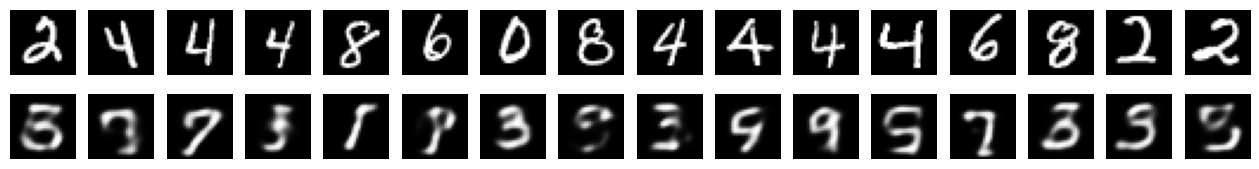

In [27]:
# Show first 16 images and reconstructed images

fig, axs = plt.subplots(2, 16, figsize=(16, 2))
for i in range(16):
    axs[0, i].imshow(imgs[i, 0], cmap="gray")
    axs[1, i].imshow(reconstructed_imgs[i, 0], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].axis("off")
plt.show()


In [ ]:
# Process 